In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
df = pd.read_csv('matched.csv')

### Introduction
The data provided here is per key-point couple which are matched within the dyncal algorithm, the attributes for each key-point are:
* x pixel location
* y pixel location
* freak angle
* descriptor
* sigma
* octave
* laplacian score
* edge score
* minima

As well as the associated attributes of the matching, dyncal back-end solution and gt errors:
* the descriptor distance (hamming distance)
* final re-projection error after re-calibration, i.e. y displacement error 
* roll, pitch, and yaw axis errors

All these samples are tagged with the dataset name and frame number

In [3]:
df.head()

,dataset_name,frame_num,x,y,angle,d_0,d_1,d_2,d_3,d_4,...,sigma.1,octave.1,laplacian_score.1,edge_score.1,minima.1,desc_distance,final_cost,roll_error,yaw_error,pitch_error
0,BathRoomLinearConst,0,454.990540,140.093643,-110.179947,51,223,254,126,55,...,8.111234,2,24.159861,4.045464,1,6,16.005184,-0.013379,0.073665,-0.049463
1,BathRoomLinearConst,0,178.902390,143.627304,-99.254578,251,31,239,219,119,...,8.511413,2,25.431593,4.220671,1,5,16.005184,-0.013379,0.073665,-0.049463
2,BathRoomLinearConst,0,365.533051,147.686752,0.000000,127,63,255,126,55,...,8.249126,2,19.326674,4.778139,1,7,16.005184,-0.013379,0.073665,-0.049463
3,BathRoomLinearConst,0,302.299561,156.668839,0.000000,1,15,230,216,17,...,7.108699,2,5.739053,10.008583,1,16,16.005184,-0.013379,0.073665,-0.049463
4,BathRoomLinearConst,0,497.892426,171.168365,0.000000,115,95,206,94,55,...,6.972685,2,24.257309,4.052949,1,8,16.005184,-0.013379,0.073665,-0.049463


### Goal
The aim of this notebook is to detail the design of a model which has learned the mapping from the key-point and matching attributes to the calibration quality achieved from Dyncal. The calibration quality can be either a binary decision good/bad (classification) or a continuous measure of quality (regression).

### Feature Selection
With domain knowledge it is useful to select or construct salient features to train the best model.
#### Key-point Coverage
Key-points which coverage all the image
#### Depth Coverage
Key-points from landmarks at various depths
#### Matching stats


In [4]:
def convert_to_polar(x_data, y_data):
    rad = []
    teh = []
    for x, y in zip(x_data, y_data):
        x -= 320
        y -= 240
        rad.append(math.sqrt(x**2 + y**2))
        teh.append(math.atan(y/x))
    return rad, teh

In [5]:
# attributes
num_matches = []
desc_dist_mean = []
desc_dist_std = []
disp_mean = []
disp_std = []
radius_mean = []
radius_std = []
theta_mean = []
theta_std = []
final_cost = []

# labels
y_error = []
p_error = []
r_error = []
error = []

for dataset in df.dataset_name.unique():
    dataset_data = df.loc[df.dataset_name == dataset]

    for i in range(100):
        frame_data = dataset_data.loc[df.frame_num == i]

        if frame_data.empty:
            break
        
        # convert cartesian coordinates to polar coordinates 
        rl, tl = convert_to_polar(frame_data["x"], frame_data["y"])
        rr, tr = convert_to_polar(frame_data["x.1"], frame_data["y.1"])
        rl.extend(rr)
        tl.extend(tr)
        rad = np.array(rl)
        teh = np.array(tl)
        
        # attributes
        num_matches.append(frame_data.shape[0])
        desc_dist_mean.append(frame_data.desc_distance.mean())
        desc_dist_std.append(frame_data.desc_distance.std())
        disp_mean.append(np.array(frame_data["x"] - frame_data["x.1"]).mean())
        disp_std.append(np.array(frame_data["x"] - frame_data["x.1"]).std())
        radius_std.append(rad.std())
        theta_std.append(teh.std())
        radius_mean.append(rad.mean())
        theta_mean.append(teh.mean())
        final_cost.append(frame_data.final_cost.mean())

        # labels
        y_error.append(abs(frame_data.yaw_error.mean()))
        p_error.append(abs(frame_data.pitch_error.mean()))
        r_error.append(abs(frame_data.roll_error.mean()))
        error.append(y_error[-1]**2 + p_error[-1]**2 + r_error[-1]**2)

Figure out the inputs and outputs. How to format data? Scale or remove outliers.
Select features:
1. number of matches
2. mean descriptor distance
3. std descriptor distance
4. angles mean
5. sigma mean
6. laplacian mean
7. edge score mean
8. final cost

Labels:
* confidence
* angular error per axis
* combine angular error

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn import linear_model
#disp_mean, disp_std, radius_std, theta_std, radius_mean, theta_mean
#num_matches, mean_dist, angles, laplacian, sigma, edge, std_dist, final_cost

X = np.vstack((num_matches, desc_dist_mean, desc_dist_std, disp_mean, disp_std, radius_mean, radius_std, theta_mean, theta_std, final_cost)).T
y = np.matrix(p_error).T

X, X_test, y, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
X_scaler = QuantileTransformer().fit(X)
X = X_scaler.transform(X)
X_test = X_scaler.transform(X_test)

In [8]:
y_scaler = QuantileTransformer().fit(y)
y = y_scaler.transform(y)
y_test = y_scaler.transform(y_test)
y = [1 if elem > 0.5 else -1 for elem in y]
y_test = [1 if elem > 0.5 else -1 for elem in y_test]

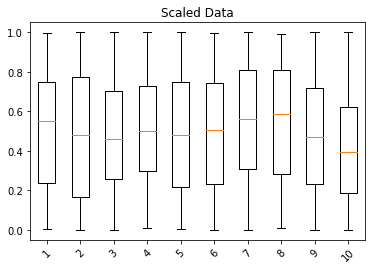

In [9]:
fig1, ax1 = plt.subplots()
ax1.set_title('Scaled Data')
# ax1.boxplot(X_test, labels=["num_matches", "mean_dist", "angles", "laplacian", "sigma", "edge", "std_dist", "final_cost"])
ax1.boxplot(X_test)

plt.setp(ax1.get_xticklabels(), rotation=45)
plt.show()

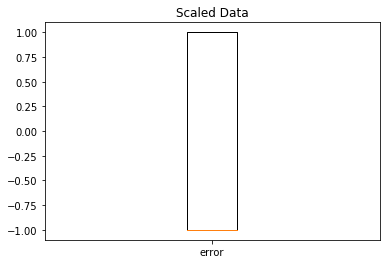

In [10]:
fig1, ax1 = plt.subplots()
ax1.set_title('Scaled Data')
ax1.boxplot(y_test, labels=["error"])
plt.show()

In [11]:
clf = linear_model.Lasso(alpha=0.01)
clf.fit(X, y)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [12]:
clf.score(X, y)

0.20275449887083316

In [13]:
from sklearn.neural_network import MLPRegressor, MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X, y)

print("Training set score: %f" % clf.score(X, y))
print("Training set loss: %f" % clf.loss_)

Training set score: 0.761062
Training set loss: 0.507155


In [14]:
y_pred = clf.predict(X_test)
print("Training set score: %f" % clf.score(X_test, y_test))

Training set score: 0.713004


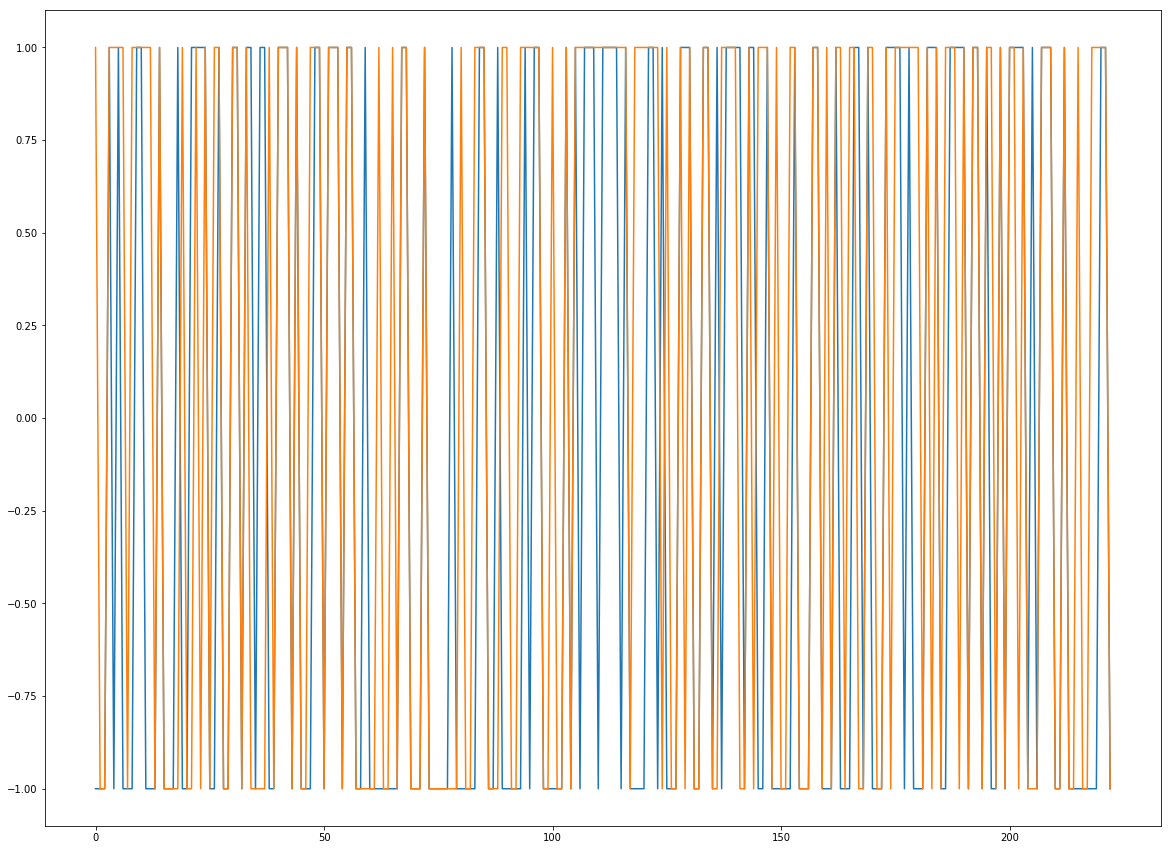

In [15]:
plt.figure(figsize=(20,15))
plt.plot(y_test);
plt.plot(y_pred);
plt.show()

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7130044843049327

#### Mean Descriptor Distance

In [18]:
      
std_dist = np.asarray(desc_dist_std)
std_dist = np.interp(std_dist, (std_dist.min(), std_dist.max()), (0.1, 200))

df["disparities"] = df["x"] - df["x.1"]

NameError: name 'mean_dist' is not defined

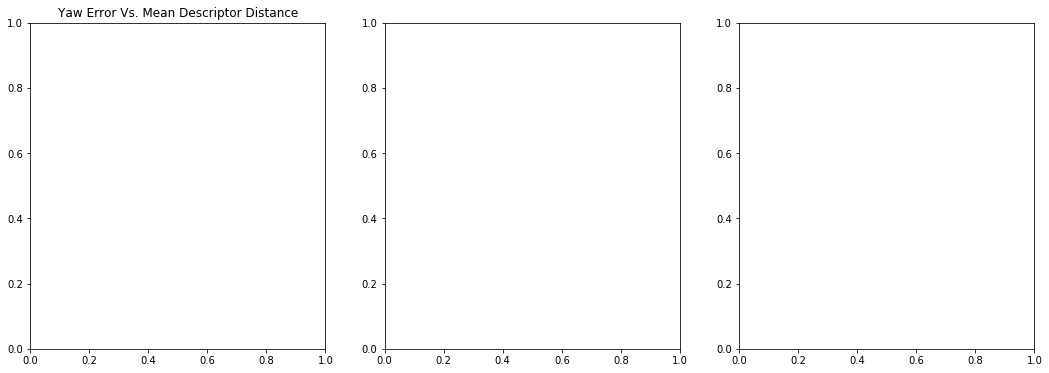

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].title.set_text("Yaw Error Vs. Mean Descriptor Distance")
ax[0].scatter(y_error, mean_dist, s=std_dist)
ax[1].title.set_text("Pitch Error Vs. Mean Descriptor Distance")
ax[1].scatter(p_error, mean_dist, s=std_dist)
ax[2].title.set_text("Roll Error Vs. Mean Descriptor Distance")
ax[2].scatter(r_error, mean_dist, s=std_dist)
plt.show()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18, 6))
ax[0].scatter(y_error, laplacian)
ax[1].scatter(p_error, laplacian)
ax[2].scatter(r_error, laplacian)
plt.show()

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18, 6))
ax[0].scatter(y_error, edge)
ax[1].scatter(p_error, edge)
ax[2].scatter(r_error, edge)
plt.show()

In [ ]:
df.boxplot(column='yaw_error', by='dataset_name', rot=45, figsize=(18, 6))
plt.title("Boxplot of Yaw Error grouped by Dataset")

# get rid of the automatic 'Boxplot grouped by group_by_column_name' title
plt.suptitle("")
plt.show()

In [ ]:
df.boxplot(column='pitch_error', by='dataset_name', rot=45, figsize=(18, 6))
plt.title("Boxplot of Pitch Error grouped by Dataset")

# get rid of the automatic 'Boxplot grouped by group_by_column_name' title
plt.suptitle("")
plt.show()

In [ ]:
df.boxplot(column='roll_error', by='dataset_name', rot=45, figsize=(18, 6))
plt.title("Boxplot of Roll Error grouped by Dataset")

# get rid of the automatic 'Boxplot grouped by group_by_column_name' title
plt.suptitle("")
plt.show()

In [ ]:
df.boxplot(column='desc_distance', by='dataset_name', rot=45, figsize=(18, 6))
plt.title("Boxplot of Roll Error grouped by Dataset")

# get rid of the automatic 'Boxplot grouped by group_by_column_name' title
plt.suptitle("")
plt.show()

In [ ]:
OF_df = df.loc[df.dataset_name == "KitchenLinearConst"]

In [ ]:
OF_df.plot(y='yaw_error', x='frame_num', figsize=(18, 6))
OF_df.plot(y='pitch_error', x='frame_num', figsize=(18, 6))
OF_df.plot(y='roll_error', x='frame_num', figsize=(18, 6))
OF_df.plot(y='final_cost', x='frame_num', figsize=(18, 6))
plt.title("Boxplot of Roll Error grouped by Image")

# get rid of the automatic 'Boxplot grouped by group_by_column_name' title
plt.suptitle("")
plt.show()

In [ ]:
OF_df.boxplot(column='desc_distance', by='frame_num', figsize=(18, 6))
plt.title("Boxplot of Roll Error grouped by Image")

# get rid of the automatic 'Boxplot grouped by group_by_column_name' title
plt.suptitle("")
plt.show()

In [ ]:

OF_df.boxplot(column='disparities', by='frame_num', figsize=(18, 6))
plt.title("Boxplot of Roll Error grouped by Image")

# get rid of the automatic 'Boxplot grouped by group_by_column_name' title
plt.suptitle("")
plt.show()